In [ ]:
import csv
import pandas as pd
import altair as alt
import numpy as np
from vega_datasets import data

In [19]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Extracting data from the transactions file

In [20]:
transactions = list()
purchases = list()
transfers = list()
topups = list()
data = dict()
users = dict()

i = 0
with open("data/transactions.csv", newline='') as csvfile:
    transreader = csv.reader(csvfile, delimiter = ' ', quotechar = '|')
    for row in transreader:
        transactions.append(row[0].split(','))
        if transactions[i][3] not in users.keys():
            users[transactions[i][3]] = 1
        else:
            users[transactions[i][3]] += 1
        if transactions[i][2] == 'PURCHASE':
            purchases.append(row[0].split(','))
            if transactions[i][4] not in data.keys():
                data[transactions[i][4]] = 1
            else:
                data[transactions[i][4]] += 1
        elif transactions[i][2] == 'USERTRANSFER':
            transfers.append(row[0].split(','))
        else:
            topups.append(row[0].split(','))
        i += 1

In [21]:
frame = pd.DataFrame({'cost in indonesian rupiah': list(data.keys()),
                     'count': list(data.values())})
frame2 = pd.DataFrame({'user': list(users.keys()),
                      'transactions': list(users.values())})

## Graph of each user's number of transactions.
##### I'm not entirely sure how this data could be useful yet, since it's separated by user.

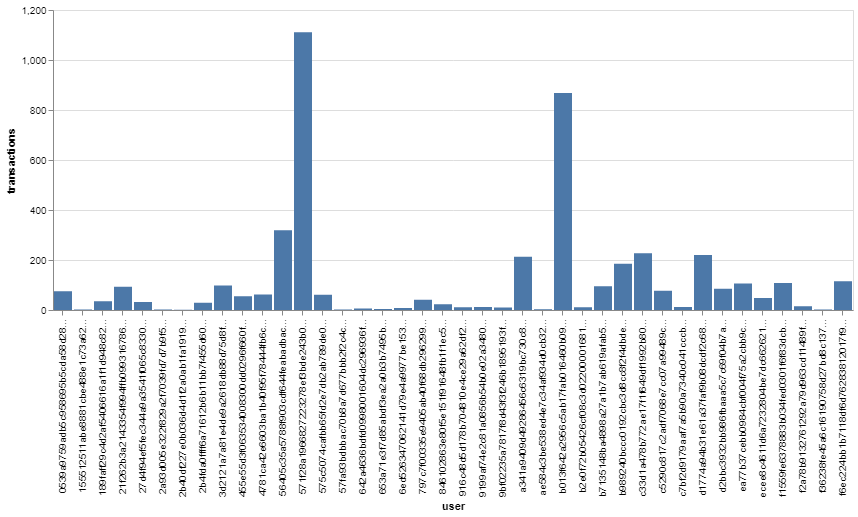

In [22]:
alt.Chart(frame2).mark_bar().encode(
    x='user',
    y='transactions'
)

## From the transactions data, a graph of the number of transactions of different costs.

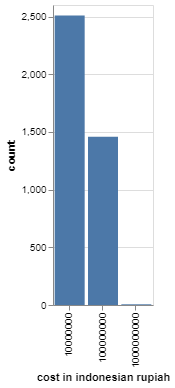

In [23]:
alt.Chart(frame).mark_bar(size=30).encode(
    x='cost in indonesian rupiah',
    y='count'
).properties(width=100)

## Graph of how much data was bought per day, in total, by the members of the Bokondini community.
##### I'm not sure if I've interpreted this wrong, but I'm surprised at how much data was purchased per day over 40 users, especially considering how much they use every day.

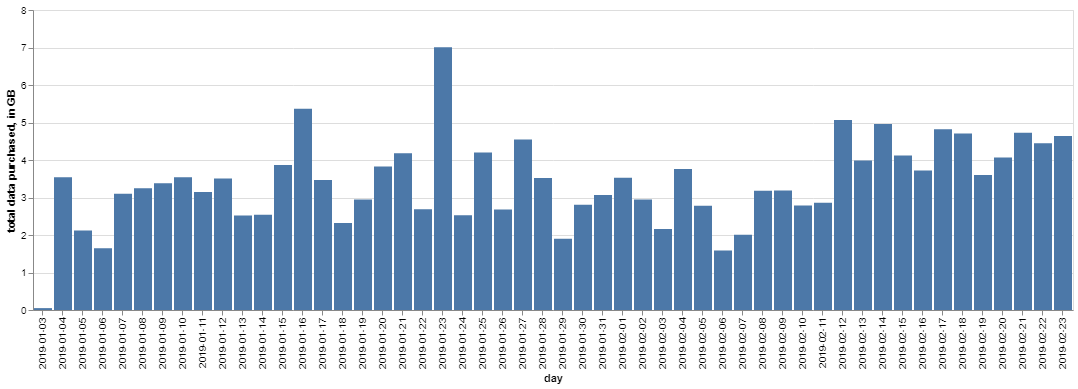

In [24]:
bytes = dict()

for entry in purchases:
    if entry[0] not in bytes:
        bytes[entry[0]] = float(entry[4]) / 1000000000
    else:
        bytes[entry[0]] += float(entry[4]) / 1000000000
        
total_data = pd.DataFrame({'day': list(bytes.keys()),
                          'total data purchased, in GB': list(bytes.values())})

alt.Chart(total_data).mark_bar().encode(
    x='day',
    y='total data purchased, in GB'
)

## Graph of how much data was transferred between users per day, in total, by the members of the Bokondini community

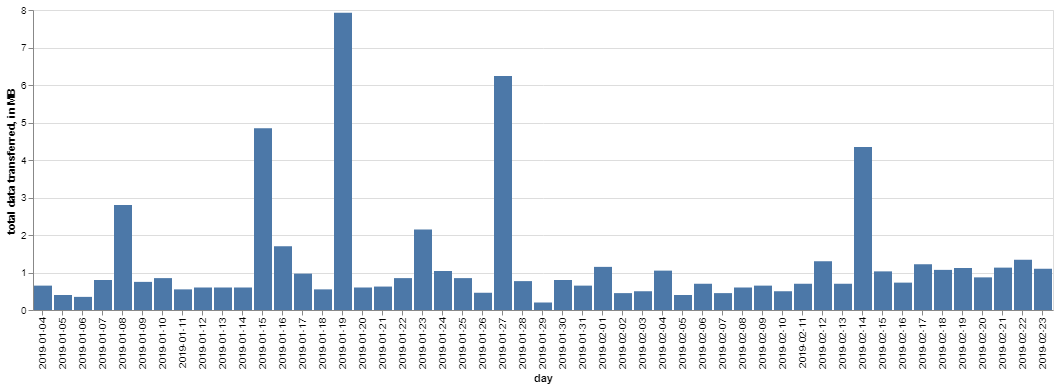

In [25]:
bytes = dict()

for entry in transfers:
    if entry[0] not in bytes:
        bytes[entry[0]] = float(entry[5].strip()) / 1000000
    else:
        bytes[entry[0]] += float(entry[5].strip()) / 1000000
        
total_data = pd.DataFrame({'day': list(bytes.keys()),
                          'total data transferred, in MB': list(bytes.values())})

alt.Chart(total_data).mark_bar().encode(
    x='day',
    y='total data transferred, in MB'
)

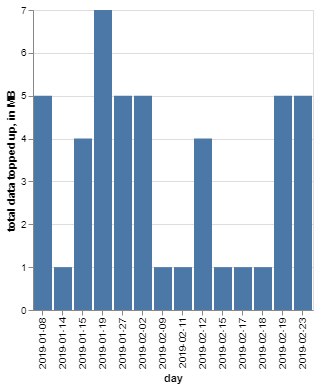

In [26]:
bytes = dict()

for entry in topups:
    if entry[0] not in bytes:
        bytes[entry[0]] = float(entry[4]) / 1000000
    else:
        bytes[entry[0]] += float(entry[4]) / 1000000
        
total_data = pd.DataFrame({'day': list(bytes.keys()),
                          'total data topped up, in MB': list(bytes.values())})

alt.Chart(total_data).mark_bar().encode(
    x='day',
    y='total data topped up, in MB'
)